Author: Judit Lozano Gondolbeu

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
import pickle
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean
import lightgbm as lgbm
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve,\
                             classification_report,  accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [7]:
#Leemos nuestra tabla de nuevo
df_data = pd.read_csv('../data/df_data.csv')
df_data.head()

,C_MNTH,C_WDAY,C_HOUR,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE,V_YEAR,C_YEAR,P_AGE,P_SEX,PP_CAR,TARGET
0,1,1,20,50,1,5,3,3,6,50,1990,1999,41,0,1,0
1,1,1,20,50,1,5,3,3,1,50,1987,1999,19,0,2,0
2,1,1,8,50,5,3,6,18,1,50,1986,1999,46,0,1,0
3,1,1,17,56,1,2,1,1,1,50,1984,1999,28,0,1,0
4,1,1,17,56,1,2,1,1,1,50,1991,1999,21,0,2,0


In [8]:
#quitamos la variable C_YEAR no disponible en el momento de hacer la predicción

df_data = df_data.drop('C_YEAR', axis=1)
df_data.head()

,C_MNTH,C_WDAY,C_HOUR,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE,V_YEAR,P_AGE,P_SEX,PP_CAR,TARGET
0,1,1,20,50,1,5,3,3,6,50,1990,41,0,1,0
1,1,1,20,50,1,5,3,3,1,50,1987,19,0,2,0
2,1,1,8,50,5,3,6,18,1,50,1986,46,0,1,0
3,1,1,17,56,1,2,1,1,1,50,1984,28,0,1,0
4,1,1,17,56,1,2,1,1,1,50,1991,21,0,2,0


### Codificación de las variables
Applicaremos la siguiente codificación según grupo de variables:

In [10]:
#Grupos por encoding a realizar
numeric_features = ['V_YEAR', 'P_AGE']  
cat_features = list(set(df_data.drop('TARGET', axis=1).columns)-set(numeric_features))

In [11]:
df_data[cat_features] = df_data[cat_features].astype(object)

In [12]:
df_data.dtypes

C_MNTH    object
C_WDAY    object
C_HOUR    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_TYPE    object
P_SAFE    object
V_YEAR     int64
P_AGE      int64
P_SEX     object
PP_CAR    object
TARGET     int64
dtype: object

### Dividimos el dataset en train y test
Dividimos el dataset en train y test manteniendo la proporción de la variable objetivo en las dos partes (separación estratificada)

In [13]:
#Definimos train y target
target = df_data[['TARGET']]
train = df_data.drop('TARGET', axis = 1)

In [14]:
all_features = train.columns
all_features

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN',
       'C_TRAF', 'V_TYPE', 'P_SAFE', 'V_YEAR', 'P_AGE', 'P_SEX', 'PP_CAR'],
      dtype='object')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify=target, shuffle=True, test_size=0.20, random_state=0)
#comprobación de la estratificación
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

TARGET
0         0.985431
1         0.014569
dtype: float64
TARGET
0         0.985432
1         0.014568
dtype: float64


In [10]:
#1st Transformer
trf1 = ColumnTransformer([
        ('catboost',ce.CatBoostEncoder(),cat_features)])

In [11]:
#2nd Transformer: Scaling
trf2 = ColumnTransformer([('scaler', StandardScaler(),slice(0,len(X_train.columns)))
                         ])

In [12]:
#5th Model
trf3 = lgbm.LGBMClassifier()

In [13]:
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['P_SAFE', 'C_RSUR', 'C_MNTH',
                                                   'C_RALN', 'C_WDAY', 'C_TRAF',
                                                   'C_HOUR', 'P_SEX', 'V_TYPE',
                                                   'C_WTHR', 'C_RCFG'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 13, None))])),
                ('trf3', LGBMClassifier())])

In [14]:
def evaluate_model(y_test, y_pred, y_pred_proba = None):
    if y_pred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, y_pred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, y_pred)))
    print('Classification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred)))

In [15]:
lgb_pred = pipe.predict(X_test)
lgb_pred_proba = pipe.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.7787884777843987
Accuracy of the model: 0.9854409858154042

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    773779
           1       0.57      0.00      0.00     11439

    accuracy                           0.99    785218
   macro avg       0.78      0.50      0.50    785218
weighted avg       0.98      0.99      0.98    785218


Confusion matrix: 
[[773759     20]
 [ 11412     27]]



### Problema de desbalanceo de datos

Para solventar este problema probaremos con la técnica SMOTE.

### SMOTE
SMOTE realiza un oversample de la clase minoritaria segun la configuracion que le demos (Ej: strategy, k-values). Por defecto, el K-value es 5 pero en este caso usaremos un k-value = 6 como ya discutimos en el estudio anterior.

In [16]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=6)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('trf3', trf3)]
modelo = Pipeline(steps=steps)
modelo.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['P_SAFE', 'C_RSUR', 'C_MNTH',
                                                   'C_RALN', 'C_WDAY', 'C_TRAF',
                                                   'C_HOUR', 'P_SEX', 'V_TYPE',
                                                   'C_WTHR', 'C_RCFG'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 13, None))])),
                ('over', SMOTE(k_neighbors=6, sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('trf3', LGBMClassifier())])

In [17]:
lgb_pred = modelo.predict(X_test)
lgb_pred_proba = modelo.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.7510564773131766
Accuracy of the model: 0.9729425458917141

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    773779
           1       0.11      0.12      0.11     11439

    accuracy                           0.97    785218
   macro avg       0.55      0.55      0.55    785218
weighted avg       0.97      0.97      0.97    785218


Confusion matrix: 
[[762597  11182]
 [ 10064   1375]]



### Regularización Ridge

Reducción de la dimensionalidad
Para evitar problemas de tiempo en la ejecución de los modelos debido al tamaño del dataset, procederemos a reducir la dimensionalidad de nuestro dataset en cuanto a las variables del mismo:

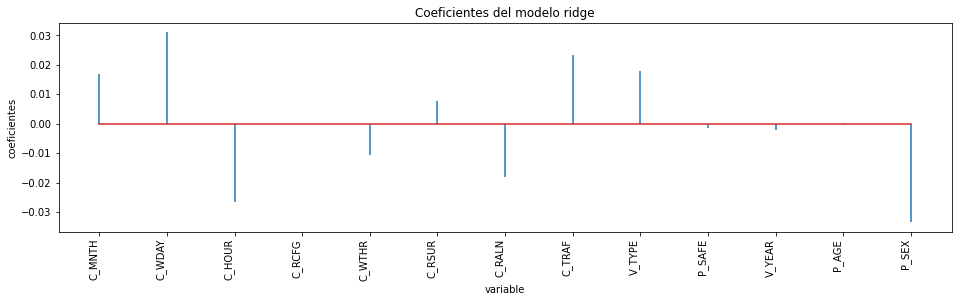

In [18]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.01)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('sel_ridge', sel_ridge)]
modelo = Pipeline(steps=steps)
modelo.fit(X_train, y_train)



sel_ridge.fit(X_train, y_train)
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [19]:
sel_ridge.get_support()
selected_feat = X_train.columns[sel_ridge.get_support()]

In [20]:
selected_feat

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_WTHR', 'C_RALN', 'C_TRAF', 'V_TYPE',
       'P_SEX'],
      dtype='object')

In [21]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 13
selected features: 8


In [22]:
selected_feat.tolist()

['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_WTHR', 'C_RALN', 'C_TRAF', 'V_TYPE', 'P_SEX']

In [23]:
#Grupos por encoding a realizar con las variables más relevantes según Ridge
cat_features = selected_feat.tolist()

In [24]:
final_features = cat_features

In [25]:
final_X_train = X_train[final_features]

In [26]:
X_test = X_test[final_features]

### Entreno del Modelo con la dimensionalidad reducida

In [27]:
#1st Transformer
trf1 = ColumnTransformer([
        ('catboost',ce.CatBoostEncoder(),cat_features)])

In [28]:
#2nd Transformer: Scaling
trf2 = ColumnTransformer([('scaler', StandardScaler(),slice(0,len(X_train.columns)))
                         ])

In [29]:
#3rd Model
trf3 = lgbm.LGBMClassifier()

In [30]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=6)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('trf3', trf3)]
modelo = Pipeline(steps=steps)
modelo.fit(final_X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['C_MNTH', 'C_WDAY', 'C_HOUR',
                                                   'C_WTHR', 'C_RALN', 'C_TRAF',
                                                   'V_TYPE', 'P_SEX'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 13, None))])),
                ('over', SMOTE(k_neighbors=6, sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('trf3', LGBMClassifier())])

In [31]:
lgb_pred = modelo.predict(X_test)
lgb_pred_proba = modelo.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.7309901877099068
Accuracy of the model: 0.968175716807307

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    773779
           1       0.06      0.08      0.07     11439

    accuracy                           0.97    785218
   macro avg       0.52      0.53      0.53    785218
weighted avg       0.97      0.97      0.97    785218


Confusion matrix: 
[[759340  14439]
 [ 10550    889]]



### Busqueda de hiperparámetros

In [32]:
params = {'trf3__n_estimators': [100, 500, 1000],
    'trf3__class_weight': [{0: 0.1, 1:0.9}, {0: 0.2, 1:0.8}], #aqui le digo que compruebe con dos diferentes pesos para las clases
    'trf3__num_leaves': [31, 50]}

grid = GridSearchCV(modelo, params, cv=4, scoring='f1')
grid.fit(final_X_train, y_train)

print(grid.best_score_)

0.07343448377596302


In [33]:
print(grid.best_params_)

{'trf3__class_weight': {0: 0.2, 1: 0.8}, 'trf3__n_estimators': 500, 'trf3__num_leaves': 50}


In [40]:
#guardamos los parametros en una nueva variable
parametros={'class_weight': {0: 0.2, 1: 0.8}, 'n_estimators': 500, 'num_leaves': 50}

In [41]:
#3rd Model
trf3 = lgbm.LGBMClassifier(**parametros)

In [42]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=6)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('trf3', trf3)]
modelo = Pipeline(steps=steps)
modelo.fit(final_X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['C_MNTH', 'C_WDAY', 'C_HOUR',
                                                   'C_WTHR', 'C_RALN', 'C_TRAF',
                                                   'V_TYPE', 'P_SEX'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 13, None))])),
                ('over', SMOTE(k_neighbors=6, sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('trf3',
                 LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, n_estimators=500,
                                num_leaves=50))])

In [43]:
lgb_pred = modelo.predict(X_test)
lgb_pred_proba = modelo.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.7288196951040828
Accuracy of the model: 0.9037872285148838

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    773779
           1       0.05      0.29      0.08     11439

    accuracy                           0.90    785218
   macro avg       0.52      0.60      0.51    785218
weighted avg       0.97      0.90      0.94    785218


Confusion matrix: 
[[706390  67389]
 [  8159   3280]]



### Guardamos el modelo entrenado para su posterior utilización

In [44]:
#me guardo el modelo entrenado para su posterior utilización
with open('../models/model_flask.pickle', 'wb') as f:
    pickle.dump(modelo, f)

In [2]:
#para traer de nuevo las variables:
#with open('../models/model_flask.pickle', 'rb') as f:
    #modelo = pickle.load(f)